In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "./data/" # Define data path

In [2]:
news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame
# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


In [3]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

In [4]:
df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

In [5]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)



In [15]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [18]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

In [20]:
cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Tue, 10 Oct 2023   Prob (F-statistic):          4.40e-196
Time:                        17:07:37   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     1452.
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:07:37   Log-Likelihood:                -3917.0
No. Observations:                6136   AIC:                             7856.
Df Residuals:                    6125   BIC:                             7930.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2329 

In [71]:
Comparison_df = y_val.join(y_pred.to_frame())
Comparison_df.columns = ['ipc', 'prediction']
Comparison_df['Error'] = (Comparison_df['ipc']-Comparison_df['prediction'])
Comparison_df['SqError'] = Comparison_df['Error']**2
Comparison_df

ipc  prediction     Error   SqError
date       district                                       
2018-05-01 Pariang     NaN         NaN       NaN       NaN
           Pibor       NaN         NaN       NaN       NaN
           Pigi        NaN         NaN       NaN       NaN
           Pochalla    NaN         NaN       NaN       NaN
           Raja        NaN         NaN       NaN       NaN
...                    ...         ...       ...       ...
2020-02-01 Wulu        2.0    2.445159 -0.445159  0.198167
           Yambio      3.0    2.443574  0.556426  0.309610
           Yei         3.0    3.214594 -0.214594  0.046051
           Yirol East  4.0    3.380657  0.619343  0.383586
           Yirol West  3.0    3.397179 -0.397179  0.157751

[1664 rows x 4 columns]

In [80]:
mse_by_district = np.sqrt(Comparison_df.groupby('district')['SqError'].mean()).to_frame()
mse_by_district

,SqError
district,
Abiemnhom,0.149025
Akobo,0.359900
Anzara,0.440311
Aweil Center,0.489416
Aweil East,0.537133
...,...
Wulu,0.471567
Yambio,0.558291
Yei,0.260498


C:\Users\alex4\AppData\Local\Temp\ipykernel_1628\3629550489.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


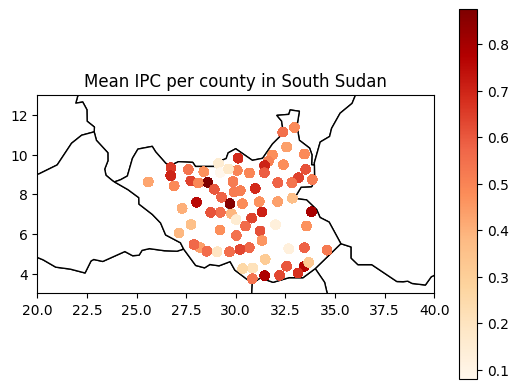

In [83]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Plot mean mse per administration on map
gdf.merge(mse_by_district, on="district").plot(
    column="SqError", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

In [84]:
len(mse_by_district)

78

In [144]:
def prep_population(a):
    a = a.replace(" ", "")
    a = a.replace(".", "")
    a = int(a)
    return a

In [155]:
population_size = pd.read_csv(data_dir + 'DC3_external_datasets/ssd_2023_population_estimates_data.csv', delimiter=';')[['Admin1','Admin2','Population - 2024']]
population_size = population_size.iloc[:-2].set_index('Admin2')
population_size['Population - 2024'] = population_size['Population - 2024'].apply(prep_population)
population_size

,Admin1,Population - 2024
Admin2,,
Abyei Administrative Area,Abyei Administrative Area,133958
Juba,Central Equatoria,690920
Kajo-keji,Central Equatoria,86973
Lainya,Central Equatoria,82153
Morobo,Central Equatoria,39642
...,...,...
Mvolo,Western Equatoria,65339
Nagero,Western Equatoria,26738
Nzara,Western Equatoria,69044


In [156]:
set(population_size.index)-set(mse_by_district.index), set(mse_by_district.index)-set(population_size.index)

({'Abyei Administrative Area',
  'Aweil Centre',
  'Bor South',
  'Canal/Pigi',
  'Kajo-keji',
  'Longochuk',
  'Luakpiny/Nasir',
  'Nzara',
  'Rumbek Centre'},
 {'Anzara',
  'Aweil Center',
  'Bor',
  'Kajo Keji',
  'Longchuk',
  'Nasir',
  'Pigi',
  'Rumbek Center'})

In [157]:
Comparison_error_population = mse_by_district.join(population_size, how = 'inner')
Comparison_error_population

,SqError,Admin1,Population - 2024
Abiemnhom,0.149025,Unity,40765
Akobo,0.359900,Jonglei,90839
Aweil East,0.537133,Northern Bahr el Ghazal,807040
Aweil North,0.655324,Northern Bahr el Ghazal,362131
Aweil South,0.642549,Northern Bahr el Ghazal,239810
...,...,...,...
Wulu,0.471567,Lakes,69428
Yambio,0.558291,Western Equatoria,138976
Yei,0.260498,Central Equatoria,181841
Yirol East,0.639317,Lakes,136988


0.016732159351138098

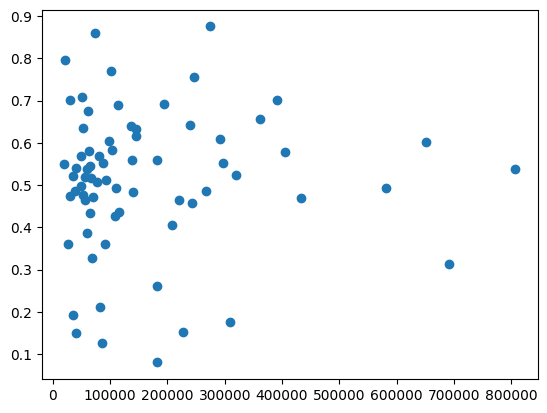

In [158]:
plt.scatter(Comparison_error_population['Population - 2024'],Comparison_error_population['SqError'])
Comparison_error_population['Population - 2024'].corr(Comparison_error_population['SqError'])

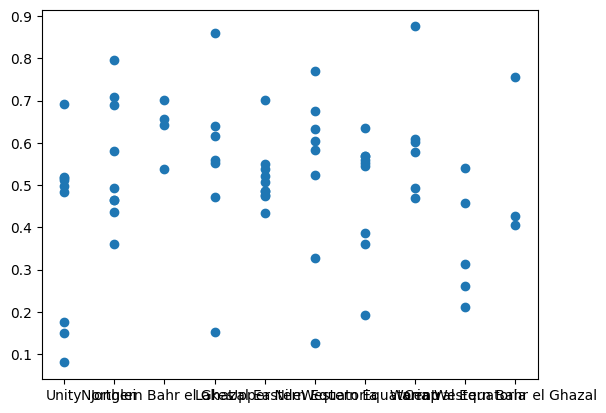

In [162]:
plt.scatter(Comparison_error_population['Admin1'],Comparison_error_population['SqError'])

In [169]:
Comparison_error_population.groupby('Admin1')['SqError'].mean().sort_values(ascending = False)

Admin1
Northern Bahr el Ghazal    0.633977
Warrap                     0.604528
Jonglei                    0.555140
Lakes                      0.550484
Eastern Equatoria          0.530113
Western Bahr el Ghazal     0.529669
Upper Nile                 0.517387
Western Equatoria          0.485218
Unity                      0.402710
Central Equatoria          0.356634
Name: SqError, dtype: float64